***
# 深層学習day2
***

### 【確認テスト】
連鎖律の原理を使い、dz/dxを求めよ。  

$$
z = t^2 ~,~ t = x + y \\
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial t} \frac{\partial t}{\partial x} = 2 t \cdot 1 = 2(x + y)
$$


## Section1: 勾配消失問題
+ 逆伝播法で勾配（0～1の値）を入力層側に掛け合わせ続けると勾配の変化がなくなり学習効果がでない
  + シグモイド関数：

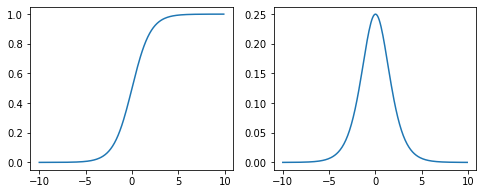

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
  return (1 - sigmoid(x)) * sigmoid(x)


x = np.arange(-10, 10, .1)

fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(x, sigmoid(x))
ax2.plot(x, d_sigmoid(x))
plt.show()

### 【確認テスト】
シグモイド関数を微分した時、入力値が0の時に最大値をとる。その値として正しいものを選択肢から選べ。  
$$
y = \frac{1}{1 + \exp(-x)} \\
y'(0) = \frac{\exp(0)}{\{ 1 + \exp(0)\}^2} = \frac{1}{(1 + 1)^2} = 0.25
$$

勾配消失問題の解決法
+ 活性化関数の選択
  + ReLU関数：0以下では0，0以上でリニア  
    勾配は0以下では0，0以上で1 ・・・不必要な重みが0になる（スパース化）
+ 重みの初期値設定
  + 乱数を使って初期化＝＞異なる初期値から学習を開始する  
  +初期化方法：Xavier（標準正規分布からランダムに設定した重みを前の層のノード数の平方根で割る）⇒　S字カーブの活性化関数で使う
    ```python
    network["W1"] = np.random.randn(input_l_size, hidden_l_size) / np.sqrt(input_l_size)
    netowrk["W2"] = np.random.randn(hidden_l_size, output_l_size) / np.sqrt(hidden_l_size)
    ```
    + 単なる標準正規分布で重みを初期化した場合，各レイヤの出力は0と1に偏る⇒逆伝播で勾配が0になりやすい
    + 標準正規分布で初期化した値を小さい値で割ると各レイヤの出力は0.5に寄る⇒学習が進まない
    + Xavierで初期化すると各レイヤの出力にばらつきが出る⇒活性化関数の表現力と勾配消失の両方に対応
  + He⇒ReLU関数などの活性化関数のときに利用
    ```python
    network["W1"] = np.random.randn(input_l_size, hidden_l_size) / np.sqrt(input_l_size) * np.sqrt(2)
    netowrk["W2"] = np.random.randn(hidden_l_size, output_l_size) / np.sqrt(hidden_l_size) * np.sqrt(2)
    ```
+ バッチ正規化
  + ミニバッチ単位での入力データの偏りを小さくする⇒中間層の学習が安定化し学習スピードが上がり，過学習が抑えられる
  + バッチサイズは2の累乗またはバイト単位が多い（ハードウェアの制約）
$$
\mu_t = \frac{1}{N_t} \sum_{i=1}^{N_t} x_{ni}~,~
\sigma_t^2= \frac{1}{N_t} \sum_{i=1}^{N_t} (x_{ni} - \mu_t)^2 \\
\hat{x}_{ni} = \frac{x_{ni}-\mu_t}{\sqrt{\sigma^2_t + \theta}}
$$
```python
mu = x.mean(axis=0) # 平均
xc = x - mu # xをセンタリング
var = np.mean(xc**2, axis=0) # 分散
std = np.sqrt(var + 10e-7) # スケーリング
xn = xc / std
```

In [ ]:
import os
import sys

sys.path.append("/content/drive/MyDrive/Study-AI/stage3") # 親ディレクトリのファイルをインポートするための設定

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net_2 import MultiLayerNet
from common.optimizer import SGD

重みを全て1で初期化した場合をシュミレーション
common.multi_layer_netのMultiLayerNetを変更common.multi_layer_net_2
```python
#common.multi_layer_net_2
# MultiLayerNetクラスの一部を改変
class MultiLayerNet:
    def __init_weight(self, weight_init_std):

        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            # 重みを1で初期化するコードを追加
            if str(weight_init_std).lower() != "const":
                self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            else:
                self.params['W' + str(idx)] = np.ones((all_size_list[idx-1], all_size_list[idx]))
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
```

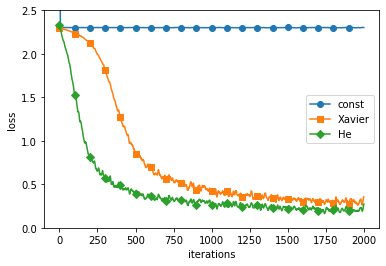

In [ ]:
# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

weight_init_types = {'const': 'const', 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

markers = {'const': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### 【確認テスト】
重みの初期値に0を設定すると、どのような問題が発生するか。簡潔に説明せよ。  
【解答】0に限らず，均一な値で初期化すると重みの値が全て同一になってしまい学習が進まない
<br>
<br>  

### 【確認テスト】
一般的に考えられるバッチ正規化の効果を2点挙げよ。  
【解答】中間層の学習が安定化し学習スピードが上がる．過学習が抑えられる．

### 【例題チャレンジ】
```python
def train(data_x, data_t, n_epoch, batch_size):
    N = len(data_x)
    for epoch in range(n_epoch):
        shuffle_idx = np.random.permutation(N)
        for i in range(0, N, batch_size):
            i_end = i + batch_size
            batch_x, batch_t = data_x[i:i_end], data_t[i:i_end]
```
+ 2重ループの内側では，全体のサンプルをバッチサイズのミニバッチのデータサブセットを生成する処理が行われている．
+ 変数iはサンプルデータを分割するための先頭インデックス番号，変数i_endは分割するための末尾インデックス番号となる．
+ 教師データの特徴量データ，ラベルデータから各ミニバッチ用のデータサブセットを抽出

【参考文献】
1. 岡谷貴之著『深層学習』講談社　2015.04
2. 斎藤康毅著『セロから作るDeepLearning』オライリー・ジャパン 2016.09
3. Aurélien Géron著、長尾 訳『scikit-learnとTensorFlowによる実践機械学習』オライリー・ジャパン 2018.04

## Section2: 学習率最適化手法

+ 勾配降下法
$$
w^{(t+1)} = w^{(t)} - \epsilon \nabla E
$$
```python
params[key] -= lr * grads[key]
```
  + 学習率が大きすぎると発散してしまう
  + 学習率が小さすぎると大域最適解に到達せず，局所最適解に収束する可能性  

<br>

固定された学習率ではなく更新処理内で学習率を変化させる  
+ モメンタム
$$
V_t = \mu V_{t-1} - \epsilon \nabla E \\
w^{(t+1)} = w^{(t)} + V_t
$$
```python
v[key] = m * v[key] - lr * grads[key]
params[key] += v[key]
```
    + 誤差をパラメータで微分したものと学習率の積を減算した後、現在の重みに前回の重みを減算した値と慣性μの積を加算する
    + なめらかな動きで大域最適解に向かう
+ AdaGrad
$$
h_0 = \theta ~,~ h_t = h_{t-1} + (\nabla E)^2 \\
w^{(t+1)} = w^{(t)} - \epsilon \frac{1}{\sqrt{h_t} + \theta}\nabla E
$$
```python
h  += gards[key]**2
params[key] -= lr * grads[key] / (h**0.5 + 1e-7)
```
  + 誤差をパラメータで微分したものと再定義した学習率の積を減算する
  + 学習が進むにつれて学習率が小さくなる
  + 鞍点問題が発生する可能性
+ RMSProp
$$
h_0 = \theta ~,~ h_t = \color{red}{\alpha} h_{t-1} +\color{red}{(1- \alpha)} (\nabla E)^2 \\
w^{(t+1)} = w^{(t)} - \epsilon \frac{1}{\sqrt{h_t} + \theta}\nabla E
$$
```python
h *= alpha
h += (1 - alpha) * grads[key]**2
params[key] -= lr * grads[key] / (h**0.5 + 1e-7)
```
  + 鞍点問題に対応
  + 過去の勾配情報の使用割合を変更可能
  + 軌跡はAdagradに類似
+ Adam
$$
m_t = \beta_1 m_{t-1} - (1-\beta_1) \nabla E \\
v_t = \beta_2 v_{t-1} + (1-\beta_2) (\nabla E)^2\\
\hat{m}_t = \frac{m_t}{1-\beta_1^t}~,~ \hat{v}_t = \frac{v_t}{1-\beta_2^t} \\
w^{(t+1)} = w^{(t)} - \epsilon \frac{1}{\sqrt{\hat{v}_t} + \theta} \hat{m}_t
$$
```python
m += beta1 * m - (1 - beta1) * grads[key]
v += beta2 * v + (1 - beta2) * grads[key]**2
mm = m / (1 - beta_1**t)
vv = v / (1 - beta_2**t)
params[key] -= lr_t * mm / (vv**0.5 + 1e-7)
```
+ モメンタムとRMSPropとの組み合わせ

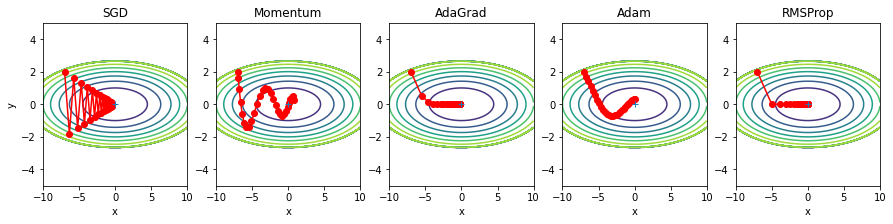

In [ ]:
import sys, os
sys.path.append("/content/drive/MyDrive/Study-AI/stage3/ch06")
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

optimizers["RMSProp"] = RMSprop(lr=0.2, decay_rate=0.99)

idx = 1

plt.figure(figsize=(15, 3))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(1, 5, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red", label=key)
    plt.contour(X, Y, Z)
    plt.ylim(-5, 5)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')

    plt.title(key)
    plt.xlabel("x")
    if idx == 2:
      plt.ylabel("y")
    
    
plt.show()

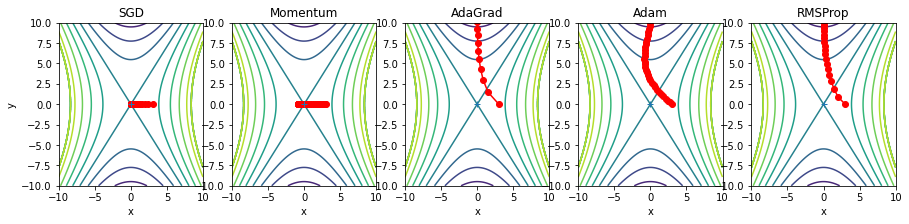

In [ ]:
def f(x, y):
    return 0.1 * x**2 - 0.05 * y**2

def df(x, y):
    return 0.2 * x, -0.1*y

init_pos = (3., 0.0001)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

optimizers["RMSProp"] = RMSprop(lr=0.1, decay_rate=0.99)

idx = 1

plt.figure(figsize=(15, 3))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(50):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-10, 10, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(1, 5, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red", label=key)
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')

    plt.title(key)
    plt.xlabel("x")
    if idx == 2:
      plt.ylabel("y")
    
    
plt.show()

+ 鞍点のある関数での比較
$$
f(x, y) = \frac{x^2}{10} - \frac{y^2}{20}
$$
割と単純な関数でのシミュレーションだったためかAdaGradでの鞍点停留は見られなかったが，SGDとモメンタムでは鞍点で停留

【参考文献】
1. 斎藤康毅著『セロから作るDeepLearning』オライリー・ジャパン 2016.09
2. Aurélien Géron著、長尾 訳『scikit-learnとTensorFlowによる実践機械学習』オライリー・ジャパン 2018.04
3. 巣籠悠輔著『詳解ディープラーニング 第2版 TensorFlow/Keras・PyTorchによる時系列データ処理』マイナビ出版 2019.11

## Section3: 過学習
+ 学習データへの精度が上がりすぎて汎化性能が落ちる
+ 入力のデータ量が少なくネットワークが大きい（層数やノード数が多い）場合に起こりやすい

<br>
ネットワークの自由度（重みの値）を制限する⇒正則化  

+ L1正則化（ラッソ回帰）
$$
E_n(\boldsymbol{w}) + \lambda || \boldsymbol{w}||
$$

+ L2正則化（リッジ回帰）
$$
E_n(\boldsymbol{w}) + \frac{\lambda}{2} || \boldsymbol{w}||^2
$$

###【確認テスト】
L1正則化を表しているグラフは？

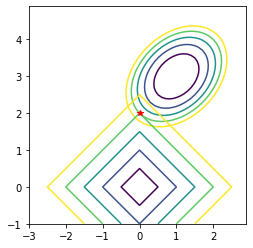

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
  return 1.5 * (x-1)**2 - 1*(x-1)*(y-3) + 1.5*(y-3)**2 

def l(x, y, lamb=1):
  return (np.abs(x) + np.abs(y)) * lamb

x = np.arange(-3, 3, 0.1)
y = np.arange(-1, 5, 0.1)
x = x.astype(np.float16)
y = y.astype(np.float16)
X, Y = np.meshgrid(x, y) 
Z1 = f(X, Y)
Z2 = l(X, Y)

plt.axes().set_aspect('equal')
plt.contour(X, Y, Z1, levels=[.5, 1., 1.5, 2.0, 2.5])
plt.contour(X, Y, Z2, levels=[.5, 1., 1.5, 2.0, 2.5])
plt.plot(0, 2, 'r*')
plt.show()

###【例題チャレンジ】
L2正則化
$$
\frac{\partial}{\partial \boldsymbol{w}}\left\{E_n(\boldsymbol{w}) + \frac{\lambda}{2} || \boldsymbol{w}||^2 \right\} = \nabla E_n(\boldsymbol{w}) + \lambda \boldsymbol{w}
$$
```python
def ridge(param, grad, rate):

  grad += rate * param
```


###【例題チャレンジ】
L1正則化
$$
\frac{\partial}{\partial \boldsymbol{w}}\left\{E_n(\boldsymbol{w}) + \lambda || \boldsymbol{w}|| \right\} = \nabla E_n(\boldsymbol{w}) \pm \lambda
$$
```python
def lasso(param, grad, rate):

  x = np.sign(param) #numpy.sign: 配列の各要素の符号を要素とする配列を返す
  grad += rate * x
```



+ ドロップアウト
  + 学習の際にランダムにノード接続を切断する
  + 学習スピードが遅くなる

【参考文献】
1. Aurélien Géron著、長尾 訳『scikit-learnとTensorFlowによる実践機械学習』オライリー・ジャパン 2018.04
2. 梅津佑太ら著『スパース回帰分析とパターン認識』講談社サイエンティフィック 2020.02

## Section4: 畳み込みニューラルネットワークの概念

+ 画像など次元に繋がりのあるデータに用いる
  + 単一チャネル
    1. 音声強度
    2. フーリエ変換音声
    3. CTスキャン
  + 複数チャネル
    1. モーションキャプチャーデータ
    2. カラー画像
    3. 動画

+ CNNの構造
  + 入力層
  + 畳み込み層
  + プーリング層
  + 全結合層
  + 出力層

+ LeNetの構造
  + 入力層:(32*32)画像データ
  + 畳み込み処理⇒(6@28*28) 6チャネル
  + 畳み込み処理⇒(6@14*14) 6チャネル
  + 畳み込み処理⇒(16@10*10) 16チャネル
  + 畳み込み処理⇒(16@5*5) 16チャネル
  + 全結合処理⇒(120)
  + 全結合処理⇒(84)
  + 出力層:(10)分類
　

+ 畳み込み層（例: 3@4*4の画像）
  + チャネルごとにフィルタ処理した結果を出力
  + フィルタは決められた大きさ分スライドさせ演算
  + (4 * 4)の入力に(3 * 3)のフィルタを使うと(2 * 2)の出力となる
  + これにバイアスを加え，活性化関数を適用

  <br>

  + 縦・横・チャネルの3次元データを3次元のまま学習し，次の層に伝える
  + 3次元の空間情報も学習できる  
  （全結合だと1次元データとして処理されてしまう）
  + フィルタ処理  
    フィルタと同じサイズのデータとの要素ごとの積の総和を出力 (4 * 4) * (3 * 3) ⇒(2 * 2)
  + フィルタとの演算を実施するとデータサイズが小さくなる
  + パディング：データサイズを大きくする  
    フィルタ処理を行う前にデータの周りにデータを追加する
      + 全て0で埋める
      + 一番近いデータの値で埋める
  + ストライド：フィルタの移動ステップ  
    ステップが大きいと出力データのサイズが小さくなる
  + チャネル：奥行き方向の次元と考える事ができる  
  縦・横と同じようにフィルタは奥行き方向にもスライドする



+ im2colアルゴリズム（演算の高速化）
  + 2次元のデータと2次元のフィルタとのアダマール積の計算を行列の内積計算に変換

+ プーリング層  
  + 2次元データの指定範囲で計算処理を行う
    + Maxプーリング:データの指定範囲の最大値を返す
    + Averageプーリング:データの指定範囲の平均値を返す
  + 学習パラメータは存在しない
  + チャネル数は変化しない


### 【確認テスト】
サイズ6×6の入力画像を、サイズ2×2のフィルタで畳み込んだ時の出力画像のサイズを答えよ。なおストライドとパディングは1とする。  
【解答】  
パディング1を加えた入力画像のサイズは8×8となる  
ストライド1で2×2のフィルタは横に7，縦に7スライドするから  
出力画像のサイズは7×7

【公式】
$$
OH = \left \lfloor\frac{H + 2P -FH}{S} \right \rfloor + 1 ~~, ~~
OW = \left \lfloor\frac{W + 2P -FW}{S} \right \rfloor + 1
$$

【コード分析】

**im2col**
```python
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3) 
    col = col.reshape(N * out_h * out_w, -1)
    return col
```
+ input_dataは(バッチサイズ, チャネル数, 縦サイズ, 横サイズ)の四次元配列
+ out_h: 出力の縦サイズ
+ out_w: 出力の横サイズ
+ numpy.pad関数:
  + 第1引数: 元データ
  + 第2引数: 各次元での前後埋め込み要素数のタプルを要素とするリスト
  + 第3引数: 埋め込み方式  
      "constant"の場合，キーワード引数constant_valuesで値を設定可能．デフォルトは0
+ img: パディング後のデータ．バッチサイズ，チャネル数にはパディング0．画像の縦方向と横方向に引数pad分だけ0を埋め込み
+ col: 戻りデータを0初期化で生成
+ ループ処理  
  4次元画像配列を6次元配列に拡張
+ numpy.array.transpose関数  
 多次元配列の軸を入れ替える

 $$
a_{(h,i,j,k,l,m)} = b_{(h,l,m,i,j,k)}
 $$
+ 配列の型を再形成

【関数全体の流れ】  

入力データの次元を拡張し，軸の入れ替え操作を実施してフィルタに対応する2次元配列を1次元配列化したものを要素とする2次元配列を生成

**Convolution**
```python
    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)


        return out
```
+ FN: フィルタのセット数．チャネルとは別でこの値により出力データチャネル数が変化する
+ 入力データxをim2col関数を使って行列に変形
+ 演算対象のフィルタもフィルタ1セットを1次元配列として行列化する
+ これら2つの行列の内積を計算する
+ 計算結果を適切な形に成型する
  
**Pooling**
```python
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        #maxプーリング
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out
```

+ 入力データをim2col関数で行列に変換
+ 1行のサイズをプーリン層の要素数で再形成
+ numpy.array.argmax関数: 配列の要素の最大値のインデックスを返す
+ maxプーリングでは行ごとに最大値のindex番号を返す
+ out:colの行ごとの最大値を要素とする配列
+ 計算結果を適切な形に成型する


【参考文献】
1. 斎藤康毅著『セロから作るDeepLearning』オライリー・ジャパン 2016.09
2. 竹縄知之 東京海洋大学大学院講義科目「深層学習」Part3 http://www2.kaiyodai.ac.jp/~takenawa/learning/lecture_Part3.pdf




## Section5: 最新のCNN

**AlexNet**  
入力画像1枚について考える
+ INPUT: 入力データ(H, W, C)は(227, 227, 3) ※原著は224だが，計算しやすいように変更
+ C1: フィルタ(FN, Fh, Fw, Fc)は(96, 11, 11, 3)でstride=4, padding=0で畳み込み処理をして処理結果(H, W, C)=(55, 55, 96)
  + 活性化関数としてReLU関数を使用し，その後に正規化(LRN)を実施
+ P1: プーリングフィルタサイズ(Fh, Fw)は(3, 3)でstride=2, padding=0でMaxプーリング処理をする．処理結果のサイズ(H, W, C)は(27, 27, 96)
+ C2: フィルタ(FN, Fh, Fw, Fc)は(256, 5, 5, 96)でstride=1, padding=2で畳み込み処理をして処理結果(H, W, C)=(27, 27, 256)
+ P2:  プーリングフィルタサイズ(Fh, Fw)は(3, 3)でstride=2, padding=0でMaxプーリング処理をする．処理結果のサイズ(H, W, C)は(13, 13, 256)
+ C3: フィルタ(FN, Fh, Fw, Fc)は(384, 3, 3, 256)でstride=1, padding=1で畳み込み処理をして処理結果(H, W, C)=(13, 13, 384)
+ C4: フィルタ(FN, Fh, Fw, Fc)は(384, 3, 3, 384)でstride=1, padding=1で畳み込み処理をして処理結果(H, W, C)=(13, 13, 384)
+ C5: フィルタ(FN, Fh, Fw, Fc)は(256, 3, 3, 384)でstride=1, padding=1で畳み込み処理をして処理結果(H, W, C)=(13, 13, 256)
+ P3:  プーリングフィルタサイズ(Fh, Fw)は(3, 3)でstride=2, padding=0でMaxプーリング処理をする．処理結果のサイズ(H, W, C)は(6, 6, 256)
+ F1: 平滑化処理．3次元データを1次元に変換処理結果のサイズ(9216)
+ D1: 全結合処理．重み行列のサイズは(9216, 4096)，変換処理結果のサイズ(4096)
+ D2: 全結合処理．重み行列のサイズは(4096, 4096)，変換処理結果のサイズ(4096)
+ D3: 全結合処理．重み行列のサイズは(4096, 1000)，変換処理結果のサイズ(1000)


In [1]:
import sys, os
sys.path.append("/content/drive/MyDrive/Study-AI/stage3/")

In [6]:
from convolution_network import *
import numpy as np
import matplotlib.pyplot as plt

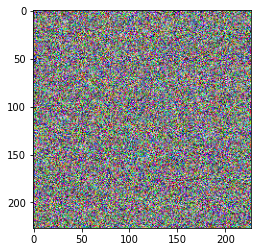

In [39]:
input_data = np.random.randint(255, size=(227, 227, 3),dtype=np.uint8)
plt.imshow(input_data)
plt.show()

In [53]:
# 入力データの成型
in1 = np.array([input_data.transpose(2, 0, 1)])
print("INPUT============")
print(in1.shape, in1.size)

# 畳み込みカーネルの初期化
filter1 = np.random.randint(0, 100, size=(96, 3, 11, 11))
# 畳み込みインスタンスの生成と演算処理
print("C1===============")
conv1 = Convolution(filter1, 0, stride=4, pad=0)
out1 = conv1.forward(in1)
print(out1.shape, out1.size)

# 活性化関数処理関連は省略

# プーリング層の生成と演算処理
print("P1===============")
pool1 = Pooling(3, 3, 2, 0)
out2 = pool1.forward(out1)
print(out2.shape, out2.size)

# 畳み込みカーネルの初期化
filter2 = np.random.randint(0, 100, size=(256, 96, 5, 5))
# 畳み込みインスタンスの生成と演算処理
print("C2===============")
conv2 = Convolution(filter2, 0, stride=1, pad=2)
out3 = conv2.forward(out2)
print(out3.shape, out3.size)

# 活性化関数処理関連は省略

# プーリング層の生成と演算処理
print("P2===============")
pool2 = Pooling(3, 3, 2, 0)
out4 = pool1.forward(out3)
print(out4.shape, out4.size)

# 畳み込みカーネルの初期化
filter3 = np.random.randint(0, 100, size=(384, 256, 3, 3))
# 畳み込みインスタンスの生成と演算処理
print("C3===============")
conv3 = Convolution(filter3, 0, stride=1, pad=1)
out5 = conv3.forward(out4)
print(out5.shape, out5.size)

# 畳み込みカーネルの初期化
filter4 = np.random.randint(0, 100, size=(384, 384, 3, 3))
# 畳み込みインスタンスの生成と演算処理
print("C4===============")
conv4 = Convolution(filter4, 0, stride=1, pad=1)
out6 = conv4.forward(out5)
print(out6.shape, out6.size)

# 畳み込みカーネルの初期化
filter5 = np.random.randint(0, 100, size=(256, 384, 3, 3))
# 畳み込みインスタンスの生成と演算処理
print("C5===============")
conv5 = Convolution(filter5, 0, stride=1, pad=1)
out7 = conv5.forward(out6)
print(out7.shape, out7.size)

# プーリング層の生成と演算処理
print("P3===============")
pool3 = Pooling(3, 3, 2, 0)
out8 = pool3.forward(out7)
print(out8.shape, out8.size)

# 平滑化処理
print("F1===============")
out9 = out8.reshape(out8.shape[0], -1)
print(out9.shape, out9.size)

# 全結合重
print("D1===============")
w1 = np.random.randn(9216, 4096)
out10 = out9.dot(w1)
print(out10.shape, out10.size)

# 全結合重
print("D2===============")
w2 = np.random.randn(4096, 4096)
out11 = out10.dot(w2)
print(out11.shape, out11.size)

# 全結合重
print("D3===============")
w3 = np.random.randn(4096, 1000)
out12 = out11.dot(w3)
print(out12.shape, out12.size)

INPUT============
(1, 3, 227, 227) 154587
C1===============
(1, 96, 55, 55) 290400
P1===============
(1, 96, 27, 27) 69984
C2===============
(1, 256, 27, 27) 186624
P2===============
(1, 256, 13, 13) 43264
C3===============
(1, 384, 13, 13) 64896
C4===============
(1, 384, 13, 13) 64896
C5===============
(1, 256, 13, 13) 43264
P3===============
(1, 256, 6, 6) 9216
F1===============
(1, 9216) 9216
D1===============
(1, 4096) 4096
D2===============
(1, 4096) 4096
D3===============
(1, 1000) 1000


【参考文献】
1. 斎藤康毅著『セロから作るDeepLearning』オライリー・ジャパン 2016.09
2. Aurélien Géron著、長尾 訳『scikit-learnとTensorFlowによる実践機械学習』オライリー・ジャパン 2018.04
3. ディープラーニング温故知新・AlexNet編 https://qiita.com/INOUEMASA/items/b1decdd6d876d88d80b5
4. AlexNet: 大規模な画像認識CNNの元祖 https://cvml-expertguide.net/2021/08/12/alexnet/